In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

np.random.seed(0)

I built a neural network with 3 hidden layers. Since my dataset (FanSpeedDS) has 5 features, I used 5 input neurons, and because I have 5 output classes, I used 5 output neurons. I randomly set up the weight connections between each layer. In the feedForward step, I use sigmoid to get outputs layer by layer, and in backPropagation, I update all weights starting from the output back to the first hidden layer so the model can learn.

In [32]:
class NeuralNetwork(object):
    def __init__(self):
        inputLayerNeurons = 5
        hiddenLayer1Neurons = 16
        hiddenLayer2Neurons = 32
        hiddenLayer3Neurons = 16
        outputLayerNeurons = 4

        self.W_IH1 = np.random.randn(inputLayerNeurons, hiddenLayer1Neurons)
        self.W_H12 = np.random.randn(hiddenLayer1Neurons, hiddenLayer2Neurons)
        self.W_H23 = np.random.randn(hiddenLayer2Neurons, hiddenLayer3Neurons)
        self.W_H3O = np.random.randn(hiddenLayer3Neurons, outputLayerNeurons)
        self.learning_rate = 0.01

    def sigmoid(self, x, der=False):
        if der == True:
          return x * (1 - x)
        else:
          return 1 / (1 + np.exp(-x))

    # Forward propagation to the parediction
    def feedForward(self, X):
        hidden1_input = np.dot(X, self.W_IH1)
        self.hidden1_output = self.sigmoid(hidden1_input)  # Getting output from hidden layer 1 neurons

        hidden2_input = np.dot(self.hidden1_output, self.W_H12)
        self.hidden2_output = self.sigmoid(hidden2_input)  # Getting output from hidden layer 2 neurons

        hidden3_input = np.dot(self.hidden2_output, self.W_H23)
        self.hidden3_output = self.sigmoid(hidden3_input) # Getting output from hidden layer 3 neurons

        output_input = np.dot(self.hidden3_output, self.W_H3O)
        pred = self.sigmoid(output_input) # Getting output from output layers

        return pred

    def backPropagation(self, X, Y, pred):
        output_error = Y - pred # Error from the final output
        output_delta = output_error * self.learning_rate * self.sigmoid(pred, True)

        hidden3_error = output_delta.dot(self.W_H3O.T)  # Error from the hidden layer3
        hidden3_delta = hidden3_error * self.learning_rate * self.sigmoid(self.hidden3_output, True)

        hidden2_error = hidden3_delta.dot(self.W_H23.T) # Error from the hidden layer2
        hidden2_delta = hidden2_error * self.learning_rate * self.sigmoid(self.hidden2_output, True)

        hidden1_error = hidden2_delta.dot(self.W_H12.T) # Error from the hidden layer1
        hidden1_delta = hidden1_error * self.learning_rate * self.sigmoid(self.hidden1_output, True)

        # Adjusting the weights
        self.W_H3O += self.hidden3_output.T.dot(output_delta)
        self.W_H23 += self.hidden2_output.T.dot(hidden3_delta)
        self.W_H12 += self.hidden1_output.T.dot(hidden2_delta)
        self.W_IH1 += X.T.dot(hidden1_delta)


    def train(self, X, Y):
        output = self.feedForward(X)
        self.backPropagation(X, Y, output)

In [33]:
try:
    df = pd.read_csv('FanSpeedDS_500.csv')
    X = df[['temp', 'cpu', 'memory', 'disk', 'network']].values
    Y_labels = df[['fanspeed']].values.astype(int) # Ensure labels are integers

    # Manual Min-Max Scaling for input features
    X_min = X.min(axis=0, keepdims=True)
    X_max = X.max(axis=0, keepdims=True)
    X_scaled = (X - X_min) / (X_max - X_min + 1e-8)

    # Adjust labels to be 0-indexed (0 to num_classes - 1)
    Y_labels_adjusted = Y_labels - 1
    num_classes = len(np.unique(Y_labels_adjusted))
    Y_onehot = np.eye(num_classes)[Y_labels_adjusted.flatten()]

except FileNotFoundError:
    print("Error: 'FanSpeedDS_500.csv' not found. Please upload the CSV file.")
    exit()

In [34]:
df.head()

,temp,cpu,memory,disk,network,fanspeed
0,78,25,79,54,3,1
1,91,98,94,47,80,4
2,68,49,74,81,98,4
3,54,24,15,6,12,1
4,82,23,7,73,38,4


Train validation split the dataset (sklearn have only been used for train val split and ROC curve)

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X_scaled, Y_onehot, test_size=0.2, random_state=42)


At first, both training and validation errors were high, showing that my model was doing poorly. Over 10,000 epochs, the training error dropped steadily, and the validation error also improved, meaning my model learned and generalized well. Since the validation error never increased, there was no overfitting. But because improvement slowed later, I could’ve used early stopping to save time without losing accuracy.




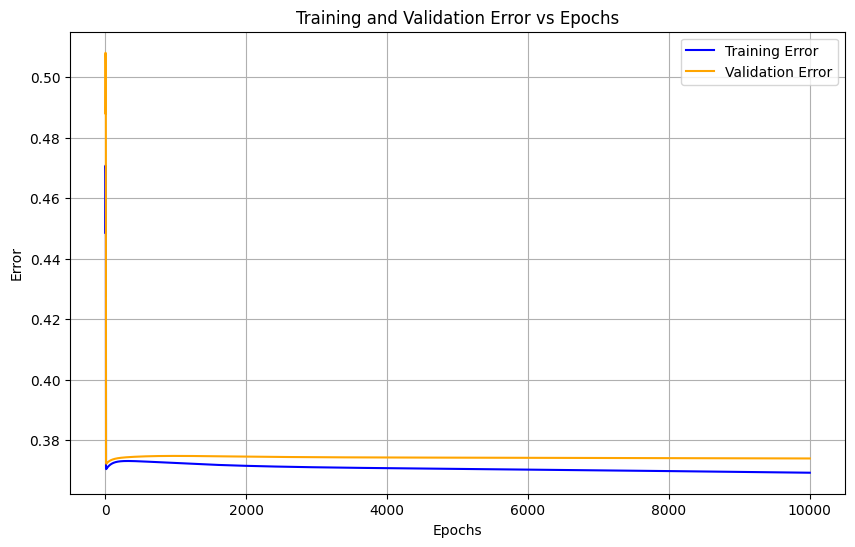

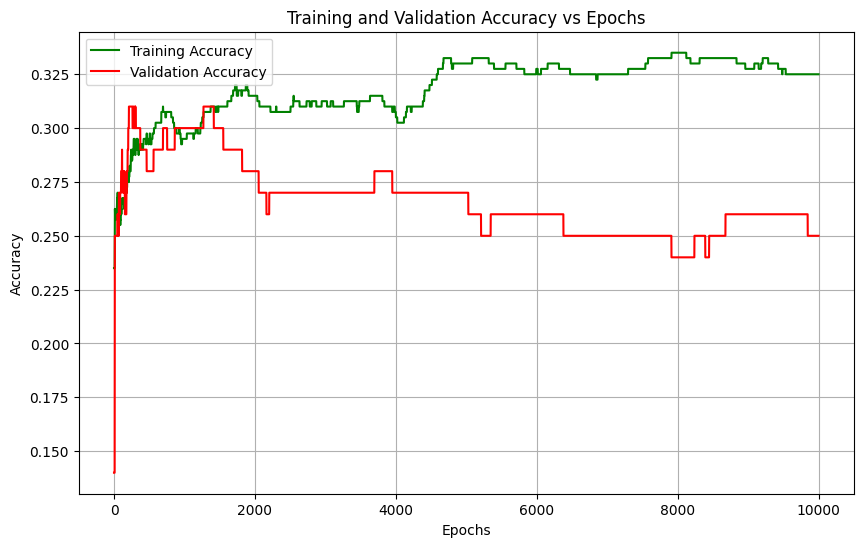

In [36]:
NN = NeuralNetwork()

train_err = []
val_err = []
train_acc = []
val_acc = []

for i in range(10000):
    NN.train(X_train, Y_train)

    # Training predictions and metrics
    train_output = NN.feedForward(X_train)
    train_loss = np.mean(np.abs(Y_train - train_output))
    train_err.append(train_loss)

    train_preds = np.argmax(train_output, axis=1)
    train_true = np.argmax(Y_train, axis=1)
    train_accuracy = np.mean(train_preds == train_true)
    train_acc.append(train_accuracy)

    # Validation predictions and metrics
    val_output = NN.feedForward(X_val)
    val_loss = np.mean(np.abs(Y_val - val_output))
    val_err.append(val_loss)

    val_preds = np.argmax(val_output, axis=1)
    val_true = np.argmax(Y_val, axis=1)
    val_accuracy = np.mean(val_preds == val_true)
    val_acc.append(val_accuracy)

# Plotting error
plt.figure(figsize=(10, 6))
plt.plot(train_err, label="Training Error", color="blue")
plt.plot(val_err, label="Validation Error", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.title("Training and Validation Error vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Plotting accuracy
plt.figure(figsize=(10, 6))
plt.plot(train_acc, label="Training Accuracy", color="green")
plt.plot(val_acc, label="Validation Accuracy", color="red")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy vs Epochs")
plt.legend()
plt.grid(True)
plt.show()



Show the predicted calss and ground truth

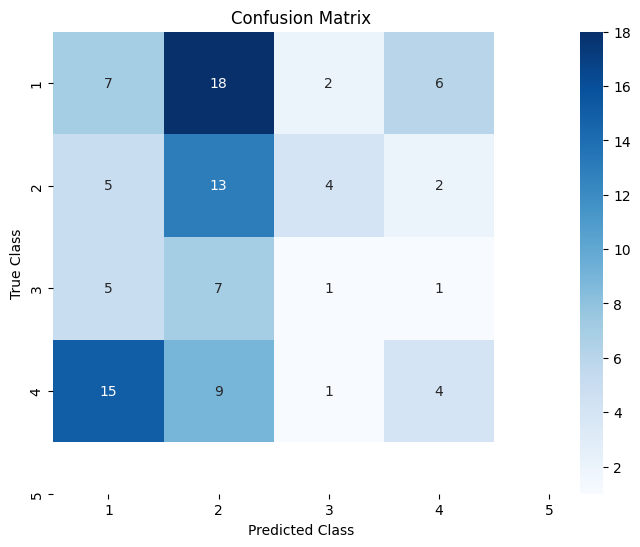

Macro-averaged F1 Score: 0.2157
Classification Report:

              precision    recall  f1-score   support

     Class 1       0.22      0.21      0.22        33
     Class 2       0.28      0.54      0.37        24
     Class 3       0.12      0.07      0.09        14
     Class 4       0.31      0.14      0.19        29

    accuracy                           0.25       100
   macro avg       0.23      0.24      0.22       100
weighted avg       0.25      0.25      0.23       100



In [37]:
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

val_output = NN.feedForward(X_val)
val_preds = np.argmax(val_output, axis=1)
val_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(val_true, val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.arange(1, 6), yticklabels=np.arange(1, 6))
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
plt.show()

f1_macro = f1_score(val_true, val_preds, average='macro')
print(f"Macro-averaged F1 Score: {f1_macro:.4f}")

print("Classification Report:\n")
print(classification_report(val_true, val_preds, target_names=[f"Class {i}" for i in range(1, 5)]))


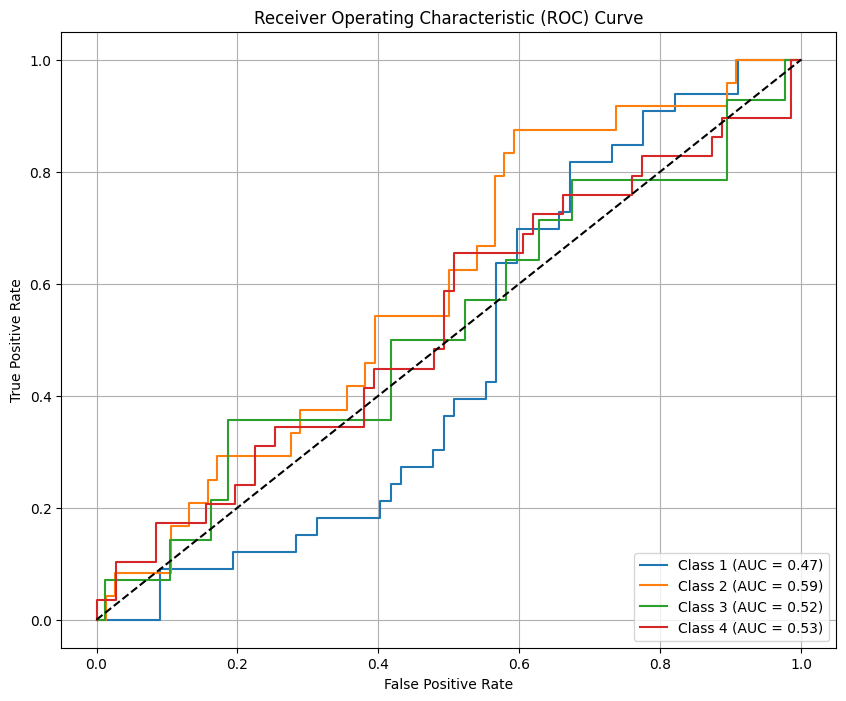

In [38]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

Y_val_binarized = label_binarize(val_true, classes=np.arange(num_classes))

val_probabilities = NN.feedForward(X_val)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_val_binarized[:, i], val_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i+1} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

My neural network with 3 hidden layers is not predicting well — the ROC curves show low AUC values close to random guessing. I used sigmoid in the output layer, which isn’t ideal for my multi-class (4-class) problem. I should replace sigmoid with softmax and use cross-entropy loss for better learning. Also, I need to normalize my data and train the model over many epochs, not just once.



